In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import skew
import math

from sklearn.linear_model import Ridge, Lasso

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from utils.dataManagers.dataSteward import DataSteward
from utils.dataManagers.informations import informer
from utils.predictions import *
from utils.dataManagers.dataWrangler import *
from utils.ClassifierResults import RegressionResults

ds = DataSteward('mapper_and_most_frequent', 'mean')
column_desc = informer.get_column_descriptions()

train = ds.train_data
test = ds.test_data
ytrain = ds.train_response

Standardization can be more practical for many machine learning algorithms. The reason is that many linear
models, such as the logistic regression and SVM initialize the weights to 0 or small random values close to 0. 
Using standardization, we center the feature columns at mean 0 with standard deviation 1 so that the feature columns take the form of
a normal distribution, which makes it easier to learn the weights. Furthermore, standardization maintains useful information about outliers and makes the
algorithm less sensitive to them in contrast to min-max scaling, which scales the data to a limited range of values.

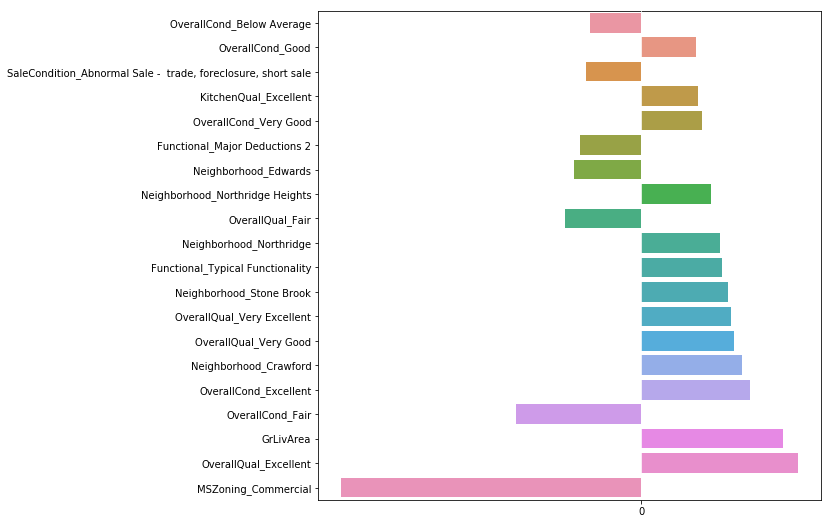

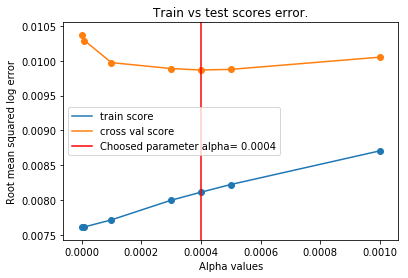

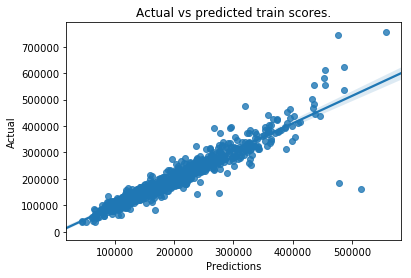

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


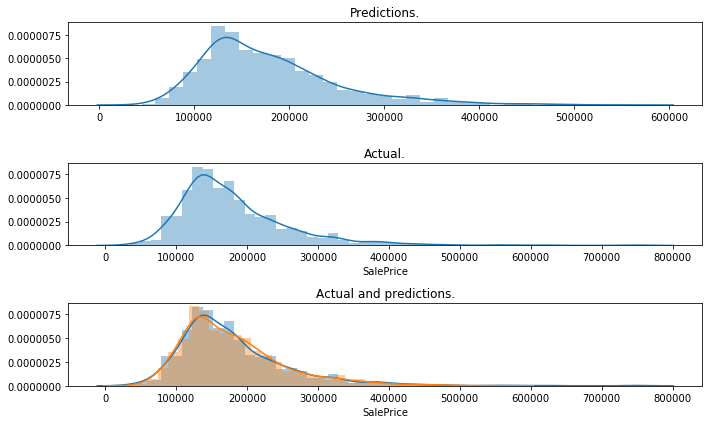

In [3]:
from scipy.stats import skew
number_type = get_number_types(train)

skewness = number_type.apply(lambda x: skew(x))
cols_to_log = skewness[np.abs(skewness.sort_values()) >= .75].index

train_log = log_given_columns(train, cols_to_log)
test_log = log_given_columns(test, cols_to_log)
trainWithDummies, testWithDummies = get_df_for_predictions(train_log, test_log)

# alphas = [0.001, 0.01, 0.03, .1, .3, .5, 1, 3, 5, 7, 10]
alphas = [1e-7, 1e-5, 1e-4, 3e-4, 4e-4, 5e-4, 1e-3]
# alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
# alphas = [10, 15, 30, 50, 75, 100, 110, 115, 120, 130, 150, 175]
param_grid = dict(alpha=alphas)

results = predict(RegressionResults, Lasso(normalize=False, max_iter=5000), param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, 
                        'lasso_loged_skewed_by_algo_columns_data_standarized_ytrain_logged',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

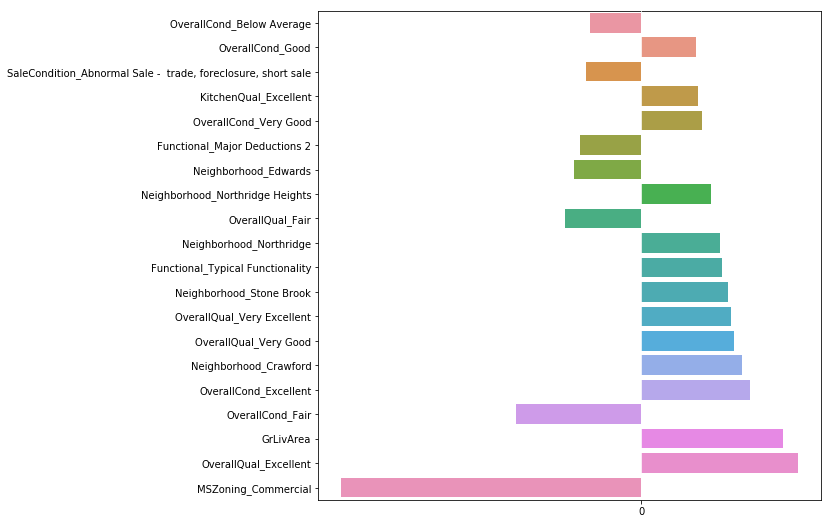

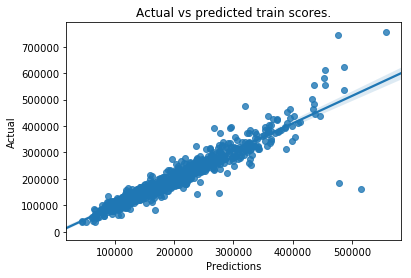

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


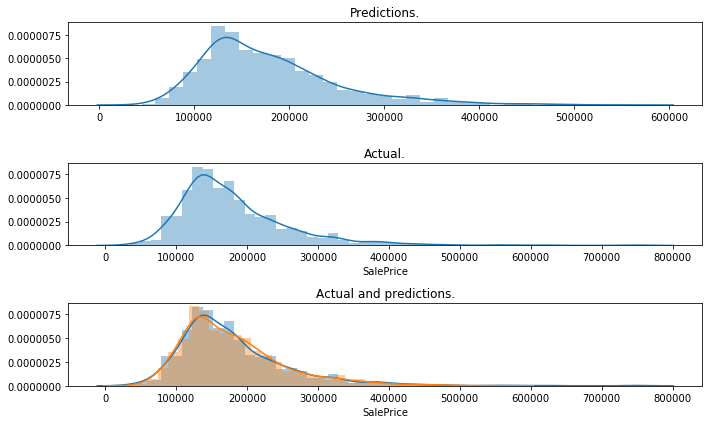

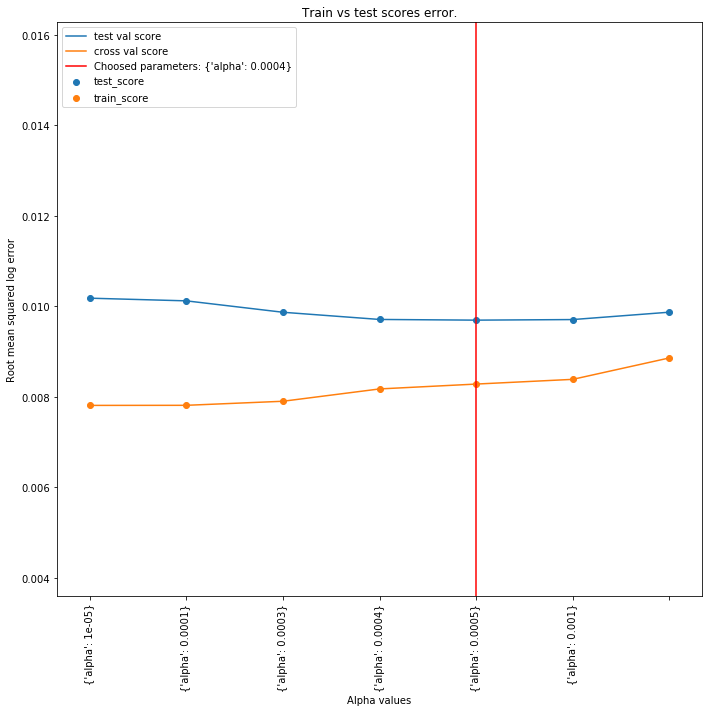

In [2]:
from scipy.stats import skew
number_type = get_number_types(train)

skewness = number_type.apply(lambda x: skew(x))
cols_to_log = skewness[np.abs(skewness.sort_values()) >= .75].index

train_log = log_given_columns(train, cols_to_log)
test_log = log_given_columns(test, cols_to_log)
trainWithDummies, testWithDummies = get_df_for_predictions(train_log, test_log)

# alphas = [0.001, 0.01, 0.03, .1, .3, .5, 1, 3, 5, 7, 10]
alphas = [1e-7, 1e-5, 1e-4, 3e-4, 4e-4, 5e-4, 1e-3]
# alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
# alphas = [10, 15, 30, 50, 75, 100, 110, 115, 120, 130, 150, 175]
param_grid = dict(alpha=alphas)

results = predict(RegressionResults, Lasso(normalize=False, max_iter=5000), param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, 
                        'lasso_loged_skewed_by_algo_columns_data_standarized_ytrain_logged',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

In [8]:
df = train.copy()
df['SalePrice'] = ytrain
corr = df.corr()

sale_price_corrs = corr.SalePrice
del corr['SalePrice']

In [9]:
def calculate_corr_rank_power(row):
    name = row.name
    corr_rank[name] = sale_price_corrs[name] / (np.sum(np.power(row.values, 2)) - 1)

def calculate_corr_rank_abs(row):
    name = row.name
    corr_rank[name] = sale_price_corrs[name] / (np.sum(np.abs(row.values)) - 1)
    
corr_rank = dict()
_ = corr.apply(calculate_corr_rank_abs, axis=1)

In [48]:
# corr_rank = dict()
# _ = corr.apply(calculate_corr_rank_power, axis=1)

In [10]:
best_corrs = np.abs(pd.Series(corr_rank))
best_corrs = best_corrs[best_corrs > np.median(best_corrs)]
if 'SalePrice' in best_corrs:
    del best_corrs['SalePrice']
best_corrs

1stFlrSF        0.077519
Fireplaces      0.087346
FullBath        0.076703
GarageArea      0.082423
GarageCars      0.083489
GarageYrBlt     0.077534
GrLivArea       0.079233
LotArea         0.077127
LotFrontage     0.072341
MasVnrArea      0.089053
OpenPorchSF     0.074233
TotRmsAbvGrd    0.072113
TotalBsmtSF     0.079471
WoodDeckSF      0.080053
YearBuilt       0.077762
YearRemodAdd    0.088816
dtype: float64

In [11]:
my_pick = ['Neighborhood', 'TotalBsmtSF', 'Heating', 'HeatingQC', 
               'BsmtFinType1', 'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageFinish', 'HouseStyle', 'MSSubClass']

#removing duplicates with set
best_columns = list(set(list(best_corrs.index) + my_pick))
len(best_columns)

26

In [12]:
def get_number_and_categoricals(df):
    return df.select_dtypes(['int64', 'float64']), df.select_dtypes(['category']) 

def get_skeved_columns(df, skew_threshold=1):
    skewness = df.apply(lambda x: skew(x))
    mask = np.abs(skewness.sort_values()) >= 1
    return mask[mask].index

def perform_data_transformations(df, columnsSubset, colsToLog):
    number_type, categorical_type = get_number_and_categoricals(df[columnsSubset])
    colsToLog_subset = [c for c in colsToLog if c in best_columns]
    
    number_type = number_type.join(number_type[colsToLog_subset].apply(np.log1p), rsuffix='_log1p')
    number_type.drop(colsToLog_subset, axis=1, inplace=True)
    return number_type.join(categorical_type)

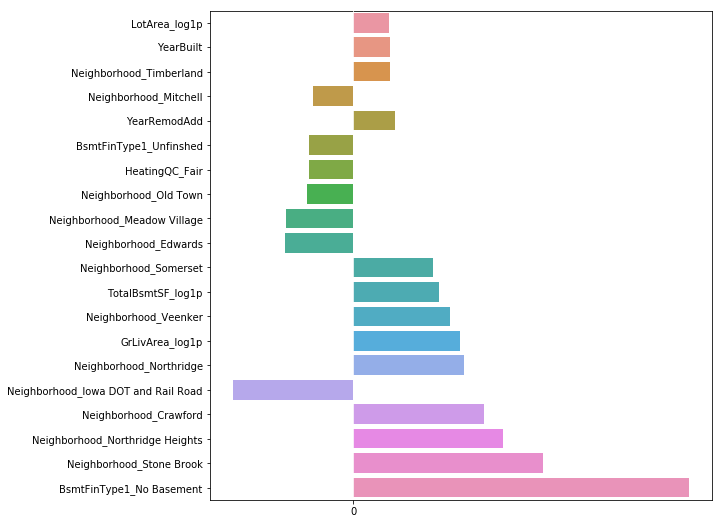

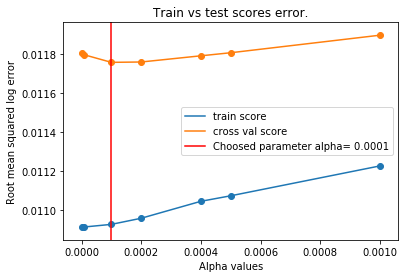

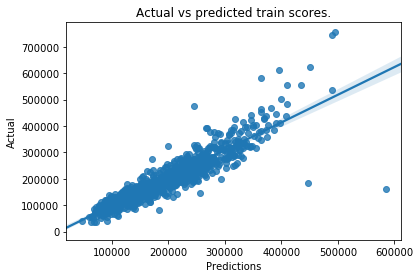

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


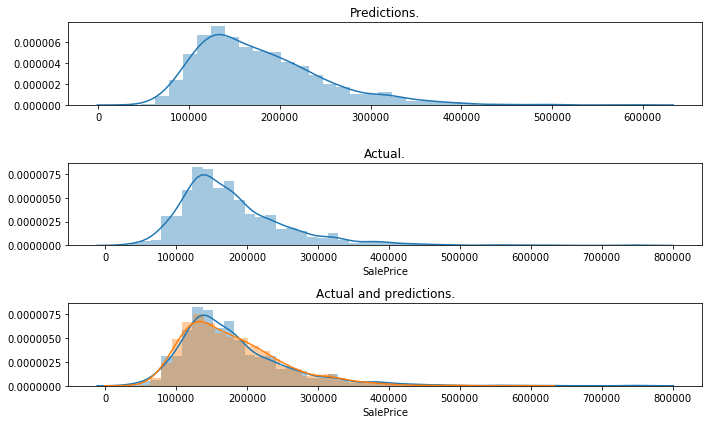

In [15]:
train = ds.train_data
test = ds.test_data
ytrain = ds.train_response

number_type = get_number_types(train)
colsToLog = get_skeved_columns(number_type, .75)
trainTransformed = perform_data_transformations(train, best_columns, colsToLog)
testTransformed = perform_data_transformations(test, best_columns, colsToLog)

trainWithDummies, testWithDummies = get_df_for_predictions(trainTransformed, testTransformed)

alphas = [1e-7, 1e-5, 1e-4, 2e-4, 4e-4, 5e-4, 1e-3]
# alphas = [1e-7, 1e-5, 1e-4, 1e-3, 3e-3, 4e-3, 5e-3, 1e-2]
# alphas = [0.001, 0.01, 0.03, .1, .3, .5, 1, 3, 5, 7, 10]
# alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
# alphas = [10, 15, 30, 50, 75, 100, 110, 115, 120, 130, 150, 175]
param_grid = dict(alpha=alphas)

results = predict(Lasso(normalize=False, max_iter=5000), param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, 
                        'lasso_loged_skewed_by_algo_columns_data_standarized_ytrain_logged',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

* somethings wrong- lot area its like 30'th best prediction
* best score is .023- best score on test is .134- so we overfit
* try using http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet

In [175]:
%%timeit
from sklearn.model_selection import cross_val_score
grid = GridSearchCV(Lasso(normalize=False), param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
cv_score = cross_val_score(grid, trainWithDummies, np.log1p(ytrain), scoring='neg_mean_squared_error', cv=5,  n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cv_score), np.std(cv_score)))

7.98 s ± 78.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
